<a href="https://colab.research.google.com/github/VicMartini/OpenCLGameOfLife/blob/main/Conway.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## OpenCL Conway's Game of Life Project

This project consist of an implementation of the popula zero player game [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) using pyOpenCL on Google Colab.

### Useful Links
- [Link to the projec's guide](https://famaf.aulavirtual.unc.edu.ar/pluginfile.php/74459/mod_resource/content/0/Guia%20Laboratorio%20OpenCL.pdf)

- I will use my [Image Transforms Project](https://colab.research.google.com/drive/1Io5dLaFlRns9JwPpUNDNZkG7FYRzNQwS) as a foundation. I'm leaving this link here as it can be useful to have quick access to that notebook.

In [1]:
!pip install pyopencl

import sys 
sys.path.append('/usr/local/lib/python3.6/site-packages')
import pyopencl as cl
import pyopencl.array as cl_array
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')


     |████████████████████████████████| 788kB 18.8MB/s 
     |████████████████████████████████| 71kB 11.3MB/s 
  Created wheel for pytools: filename=pytools-2021.1-py2.py3-none-any.whl size=60415 sha256=8f6ef77ccff9e6edb262e659080aa811e7136fde46e9c3196a12a9de0a4eeeac
  Stored in directory: /root/.cache/pip/wheels/5d/85/10/7da05d77b47f2cb503e5c4185ba82187d0b6b6736b3c6641e0
Successfully built pytools


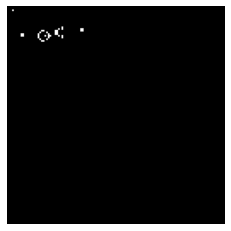

In [ ]:
np.set_printoptions(threshold=sys.maxsize)

# Living cells in the initial state.
L = [[8,16],[8,17],[9,16],[9,17],[3,2],[18,16],[18,17],[18,18],[19,15],[19,19],
     [20,14],[20,20],[21,14],[21,20],[22,17],[23,15],[23,19],[24,16],[24,18],[24,17],
     [25,17],[28,16],[28,15],[28,14],[29,16],[29,15],[29,14],[30,17],[30,13], [32,17],[32,13],
     [32,18],[32,12],[43,13],[44,13],[43,14],[44,14]]

#Definitions of the size of the matrix and the number of iterations to run
N = 128
K = 1000

#Generate initial matrix
initial_matrix = np.zeros(N*N, dtype=np.float32)
for p in L:
  initial_matrix[p[1]*N+p[0]]= 1



#Show the initial matrix. 
fig, ax = plt.subplots()
ax.imshow(np.reshape(initial_matrix,(N,N)), cmap='gray')
plt.axis('off')
plt.show()

#Declare array for the result
generations = [np.zeros(N*N, dtype=np.float32) for i in range(K)]



In [ ]:
!nvidia-smi

Wed Feb 17 19:57:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    21W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
computeNextMatrix = """__kernel void computeNextMatrix(
      __global float* dest_data, __global const float* src_data, int N){
          // Get global ID for output coordinates
          int x = get_global_id(0);
          int y = get_global_id(1);
          
          float alive_cells = 0; 
          for (int i = x-1; i <= x+1; ++i)
          {
            for (int j = y-1; j <= y+1; ++j)
            {
              if (!(i == x && j == y))
                alive_cells+=src_data[j*N+i] ;
            }
          }
    
          if (src_data[y*N+x])
          {
            if (alive_cells == 2 || alive_cells == 3)
              dest_data[y*N+x] = 1.;
            else
              dest_data[y*N+x] = 0.;
          }
          else
          {
            if (alive_cells == 3)
              dest_data[y*N+x] = 1.;
            else
              dest_data[y*N+x] = 0.;
          }
      }
  """

In [ ]:
# ---------------Set up environment-----------------------------------

# > Discover platform
platform_list = cl.get_platforms()              
devices = platform_list[0].get_devices(device_type=cl.device_type.GPU)
# > Create context 
context = cl.Context(devices=devices)
# > Create the out of order command queue
queue = cl.CommandQueue(context, properties=cl.command_queue_properties.OUT_OF_ORDER_EXEC_MODE_ENABLE)
# > Set memory flags
mf = cl.mem_flags
  

#---------------Declare buffers and move data----------------------------

def createBuffers(sourceArray, destinationArray):
  buffers = []
  buffers.append(cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=sourceArray))
  buffers.append(cl.Buffer(context, mf.READ_WRITE, destinationArray.nbytes))
  return buffers



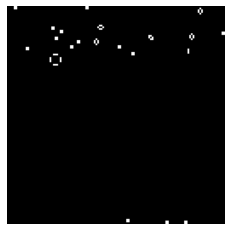

In [ ]:
# Declare program
computeNextMatrixProgram = cl.Program(context, computeNextMatrix).build()
buff = createBuffers(initial_matrix, generations[0])
globalrange = (N, N)
localrange = None

def genKernels():
  newKernels = []
  for i in range (K):
    newKernel = computeNextMatrixProgram.computeNextMatrix
    newKernel.set_scalar_arg_dtypes([None, None, np.int32])
    newKernel.set_args(buff[(i+1)%2], buff[i%2], N)
    newKernels.append(newKernel)
  return newKernels

kernels = genKernels()


def enqueueKernels(kernelList, queue):
  events = []
  for i, kernel in enumerate(kernelList):
    if i == 0:
      events.append(cl.enqueue_nd_range_kernel(queue, kernel, globalrange, localrange))
      events.append(cl.enqueue_copy(queue, generations[i], buff[(i+1)%2], wait_for=[events[0]]))

    elif i < len(kernelList ):
      events.append(cl.enqueue_nd_range_kernel(queue, kernel, globalrange, localrange, wait_for=[events[i*2-1]]))
      events.append(cl.enqueue_copy(queue, generations[i], buff[(i+1)%2], wait_for=[events[i*2]]))

  return events

enqueueKernels(kernels, queue)

fig, ax = plt.subplots()
ims = []
for i, image in enumerate(generations):
  im = ax.imshow(generations[i].reshape(N,N), cmap='gray', animated = True)
  ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
plt.axis('off')

ani